# Data Upload

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

import torch as torch

import tensorflow_datasets as tfds
import random 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.util import montage

import pandas as pd
import cv2
import keras
import numpy as np


from sklearn.metrics import accuracy_score
from tqdm.autonotebook import tqdm

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
def see_data(i):
    print("---Showing img #" + str(i) +"---")
    print("Shape: " + str(training_data[i][0].shape))
    print("Label: " +  str(training_data[i][1] + 1))
    print("Array: " + str(training_data[i][0]))
    plt.imshow(training_data[i][0])
    plt.show()
    print("---Show done---")

def see_data_t(i):
    print("---Showing img #" + str(i) +"---")
    print("Shape: " + str(training_data[i][0].shape))
    print("Array: " + str(training_data[i][0]))
    plt.imshow(training_data[i][0])
    plt.show()
    print("---Show done---")

def print_perc(l):
    c1=0
    c2=0
    c3=0
    c4=0
    c5=0
    total = len(l)
    for label in l:
        if(label == 0):
            c1 += 1
        if(label == 1):
            c2 += 1
        if(label == 2):
            c3 += 1
        if(label == 3):
            c4 += 1
        if(label == 4):
            c5 += 1
    
    print("Percentage of 1: %" + str(format( c1/total*100, '.2f') ) )
    print("Percentage of 2: %" + str(format( c2/total*100, '.2f') ) )
    print("Percentage of 3: %" + str(format( c3/total*100, '.2f') ) )
    print("Percentage of 4: %" + str(format( c4/total*100, '.2f') ) )
    print("Percentage of 5: %" + str(format( c5/total*100, '.2f') ) )


In [0]:
import pickle

IMG_SIZE = 128
training_data = []
# should be changed to your own path to the pickle database path,"rb" keyword should be stay as it is (it is for reading from the pickle database)
training_data = pickle.load(open("/content/drive/My Drive/CS412 PROJECT/Final Notebooks/pickle/Training_data_trimmed_crop.pickle", "rb"))

In [0]:
# for i in range(len(training_data)):
#     training_data[i][0] = cv2.resize(training_data[i][0], (IMG_SIZE,IMG_SIZE))

# Split and Modify Data

In [0]:
print(len(training_data))

10000


---Showing img #31---
Shape: (128, 128, 3)
Label: 1
Array: [[[ 5  1  0]
  [ 5  1  0]
  [ 3  2  0]
  ...
  [ 1  0  2]
  [ 5  0  1]
  [ 6  0  2]]

 [[ 3  0  0]
  [ 4  0  0]
  [ 2  1  0]
  ...
  [ 2  0  3]
  [ 5  1  2]
  [ 6  2  3]]

 [[ 3  0  0]
  [ 4  0  0]
  [ 3  2  0]
  ...
  [ 2  0  3]
  [ 4  2  5]
  [ 5  3  6]]

 ...

 [[ 1  0  8]
  [ 1  0  8]
  [ 0  0  5]
  ...
  [ 3  1  2]
  [ 4  0  0]
  [ 7  1  1]]

 [[ 2  0  8]
  [ 0  0  7]
  [ 0  0  7]
  ...
  [ 4  0  1]
  [ 5  0  0]
  [10  1  2]]

 [[ 4  1 10]
  [ 1  0  8]
  [ 0  0  7]
  ...
  [ 5  1  2]
  [ 9  0  3]
  [14  4  5]]]


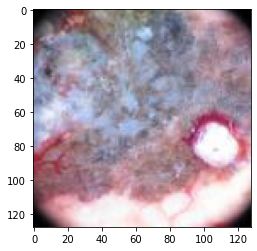

---Show done---


In [0]:
see_data(31)

# Transfer Leaning

In [0]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)   #gray scale 1 --> 3 for RGB
y = np.array(y)

In [0]:
X = X/255.0

In [0]:
X, valid_X, y, valid_y = train_test_split(X, y, test_size = 0.1, random_state=3) # used train test split method


#test_X, valid_X, test_y, valid_y = train_test_split(valid_X, valid_y, test_size = 0.5, random_state=3,shuffle = True)

print(X.shape,y.shape,valid_X.shape,valid_y.shape)

(9000, 128, 128, 3) (9000,) (1000, 128, 128, 3) (1000,)


In [0]:
X[0].shape

(128, 128, 3)

In [0]:
y = to_categorical(y,5)
valid_y = to_categorical(valid_y,5)

In [0]:
print(y.shape)

(9000, 5)


In [0]:
training_data = []

# Modelling

In [0]:
pre_trained_model = InceptionResNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
print("Model Loaded")

219062272/219055592 [==============================] - 15s 0us/step
Model Loaded


In [0]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_9
batch_normalization_9
activation_9
conv2d_7
conv2d_10
batch_normalization_7
batch_normalization_10
activation_7
activation_10
average_pooling2d_1
conv2d_6
conv2d_8
conv2d_11
conv2d_12
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
activation_6
activation_8
activation_11
activation_12
mixed_5b
conv2d_16
batch_normalization_16
activation_16
conv2d_14
conv2d_17
batch_normalization_14
batch_normalization_17
activation_14
activation_17
conv2d_13
conv2d_15
conv2d_18
batch_normalization_13
batch_normalization_15
batch_normalization_18
activation_13
activation_15
activation_18
block35_1_mixed
block35_1_conv
block35_1
block35_1_ac
conv2d_22
batch_normalization_22
activation_22
conv2d_20
c

In [0]:
last_layer = pre_trained_model.get_layer('conv_7b_ac')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 2, 2, 1536)


In [0]:
# Flatten the output layer to 1 dimension

x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)

optimizer = Adam(lr=0.0001, decay=0.0, amsgrad=True)

model.compile(loss='categorical_crossentropy',
              optimizer= optimizer,
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X)

val_datagen = ImageDataGenerator()
val_datagen.fit(valid_X)
print(valid_X.shape[0])

1000


In [0]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X,y, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(valid_X, valid_y),
                              verbose = 1, steps_per_epoch=(X.shape[0] // batch_size), 
                              validation_steps=(valid_X.shape[0] // batch_size))

Epoch 1/3
140/140 [==============================] - 190s 1s/step - loss: 1.4691 - accuracy: 0.4174 - val_loss: 1.3672 - val_accuracy: 0.4875
Epoch 2/3
140/140 [==============================] - 127s 910ms/step - loss: 1.2858 - accuracy: 0.4861 - val_loss: 1.2427 - val_accuracy: 0.5729
Epoch 3/3
140/140 [==============================] - 128s 913ms/step - loss: 1.2477 - accuracy: 0.5049 - val_loss: 1.3051 - val_accuracy: 0.5724


In [0]:
pre_trained_model.layers[617].name

'mixed_7a'

In [0]:
for layer in pre_trained_model.layers[618:]:
    layer.trainable = True

In [0]:
optimizer = Adam(lr=0.0001,decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
batch_size = 64
epochs = 25
history = model.fit_generator(train_datagen.flow(X,y, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(valid_X, valid_y),
                              verbose = 1, steps_per_epoch=(X.shape[0] // batch_size),
                              validation_steps=(valid_X.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/25
140/140 [==============================] - 193s 1s/step - loss: 1.2415 - acc: 0.5613 - val_loss: 1.0518 - val_acc: 0.5771
Epoch 2/25
140/140 [==============================] - 133s 954ms/step - loss: 1.0016 - acc: 0.6140 - val_loss: 0.8554 - val_acc: 0.6500
Epoch 3/25
140/140 [==============================] - 133s 953ms/step - loss: 0.9452 - acc: 0.6401 - val_loss: 0.9630 - val_acc: 0.6228
Epoch 4/25
140/140 [==============================] - 134s 954ms/step - loss: 0.9101 - acc: 0.6586 - val_loss: 1.2946 - val_acc: 0.6833
Epoch 5/25
140/140 [==============================] - 133s 952ms/step - loss: 0.8607 - acc: 0.6750 - val_loss: 0.8503 - val_acc: 0.6645
Epoch 6/25
140/140 [==============================] - 133s 952ms/step - loss: 0.8314 - acc: 0.6861 - val_loss: 0.7109 - val_acc: 0.6771
Epoch 7/25
140/140 [==============================] - 133s 951ms/step - loss: 0.8051 - acc: 0.6924 - val_loss: 0.8648 - val_acc: 0.6579

Epoch 00007: ReduceLROnPlateau reducing learning r

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=1)

In [0]:
history = model.fit_generator(train_datagen.flow(X,y, batch_size=batch_size),
                              epochs = 5, validation_data = val_datagen.flow(valid_X, valid_y),
                              verbose = 1, steps_per_epoch=(X.shape[0] // batch_size),
                              validation_steps=(valid_X.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/5
140/140 [==============================] - 135s 961ms/step - loss: 0.4030 - acc: 0.8535 - val_loss: 0.8408 - val_acc: 0.7000
Epoch 2/5
140/140 [==============================] - 134s 957ms/step - loss: 0.4017 - acc: 0.8515 - val_loss: 1.0323 - val_acc: 0.6958
Epoch 3/5
140/140 [==============================] - 135s 962ms/step - loss: 0.3935 - acc: 0.8519 - val_loss: 0.8380 - val_acc: 0.7127
Epoch 4/5
140/140 [==============================] - 135s 964ms/step - loss: 0.3921 - acc: 0.8569 - val_loss: 0.6498 - val_acc: 0.7146
Epoch 5/5
140/140 [==============================] - 135s 963ms/step - loss: 0.3835 - acc: 0.8578 - val_loss: 0.8173 - val_acc: 0.7149


In [0]:
X = []
y = []

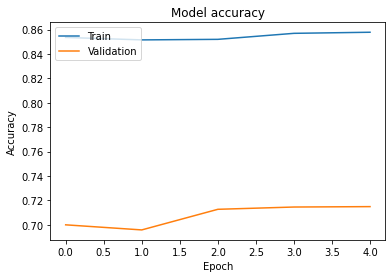

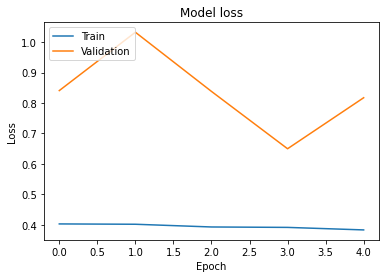

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
loss_val, acc_val = model.evaluate(valid_X, valid_y, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1000/1000 [==============================] - 7s 7ms/step
Validation: accuracy = 0.715000  ;  loss_v = 0.856672


In [0]:
#test_y2 = to_categorical(test_y,5)

In [0]:
# loss_test, acc_test = model.evaluate(test_X, test_y2, verbose=1)
# print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

1000/1000 [==============================] - 3s 3ms/step
Test: accuracy = 0.723000  ;  loss = 2.394874


In [0]:
# test_pred = np.argmax(model.predict(test_X),-1)
# acc = accuracy_score(test_y,test_pred)

# print(acc)

0.723


In [0]:
# should be changed to your own path on where you will save the model and weight

model.save("/content/drive/My Drive/CS412 PROJECT/Final Notebooks/models/InceptionResNetV2_model_crop.h5")
model.save_weights("/content/drive/My Drive/CS412 PROJECT/Final Notebooks/weights/InceptionResNetV2_model_weights_crop.h5")

# Real Test

In [0]:
# testing_data = []

In [0]:
# testing_data = pickle.load(open("/content/drive/My Drive/CS412 PROJECT/Final Notebooks/pickle/Testing_data_trimmed.pickle", "rb"))

In [0]:
# print(len(testing_data))

In [0]:
# for i in range(len(testing_data)):
#     testing_data[i] = cv2.resize(testing_data[i], (IMG_SIZE,IMG_SIZE) )

In [0]:
# print(len(testing_data))

In [0]:
# see_data_t(1006)

In [0]:
# testing_data = np.array(testing_data).reshape(-1,IMG_SIZE,IMG_SIZE,3)

# testing_data = testing_data / 255.0

# len(testing_data)

In [0]:
# predictions = np.argmax(model.predict(testing_data),-1)

In [0]:
# results = []
# for i in range(len(predictions)):
#     results.append(predictions[i]+1)

In [0]:
# print(results)

# Printing Data to CSV

In [0]:
# from google.colab import files

# fileName = "8k_50x50_2x2_64-128_128-256.csv"

# def printResult(images,labels): 
#     file = open(fileName,"w")

#     if(len(images) != len(labels)):
#         print("Error with the dimensions.")
#         return False
#     else:
#         file.write("Id,Category\n")
#         for i in range(len(images)):
#             file.write( str(images[i]) + "," + str(labels[i]) + "\n")
#         return True

# csv_images = []
# for i in range(10001,15001):
# 	csv_images.append("Image_" + str(i))

# if( printResult(csv_images,results) ):
#     files.download(filename= fileName)
# else:
#     print("Cannot download...")